In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image, ImageDraw
import matplotlib.lines as lines
from tqdm import tqdm
import glob

import statistics 

#For network adjacency checks
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#For PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import warnings

np.seterr(all='raise')
scipy.special.seterr(all='raise')

{'singular': 'ignore',
 'underflow': 'ignore',
 'overflow': 'ignore',
 'slow': 'ignore',
 'loss': 'ignore',
 'no_result': 'ignore',
 'domain': 'ignore',
 'arg': 'ignore',
 'other': 'ignore'}

In [2]:
#Class object for network:
'''contains: the base image
the adjacency list
the graph
notable properties calculated on initialize
clustering (to be fixed) on call
visualization functions for graph on image and graph alone'''

class network_object:
    #network object - takes in a (full) segmentation output and initializes a network-object with notable properties calculated
    #
    
    def __init__(self, instances, tag, img = None):
        
        self.image = img
        self.instances = instances
        self.tag = tag
        
        #boxes = np.array(instances['pred_boxes'])
        #polygons = np.array(instances['pred_masks'])
        #scores = np.array(instances['scores'])
        
        self.number = len(self.instances['pred_boxes'])
        self.density = self.number/(instances['image_size'][0]*instances['image_size'][1])
        self.avgscore = sum(self.instances['scores'])/self.number
        
        self.densityHistogram = 0
        self.centroid_list = self.construct_centroid_list(self.instances)
        #self.polygon_list = self.construct_polygon_list(self.instances)
        
        self.adjacency_list = self.construct_adjacencies(self.instances)
        
        self.graph = self.construct_graph(self.adjacency_list)
        
        self.num_components = len(self.get_component_masses())
        
        self.fractal_dim = None
        
        
    def construct_centroid_list(self, instances):
        return np.array([ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ])
    
    def construct_polygon_list(self, instances):
        return [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]
        
    #Definition of mindist parameter -------------------------------------------------------------------------------------
    def construct_adjacencies(self, instances, mindist = 10):
        #takes a list of n cell_poly objects
        #takes a minimum distance defined as adjacent
        #returns an adjacency list of length n

        adjacency_list = []
        wide_list = []

        centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
        centroid_list = np.array(centroid_list)
        polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

        tree = []
        tree = KDTree(centroid_list, leaf_size=10)

        wide_list = tree.query_radius(centroid_list, mindist * 5)

        for i,small_list in enumerate(wide_list):
            adjacency_list.append (list())
            for index in small_list:
                # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
                if index <= i:
                    continue
                d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
                if min(d.flatten()) < mindist:
                    adjacency_list[i].append (index)

        return adjacency_list
        
    def construct_graph(self, adjacency_list):
        g = nx.Graph()
        for i in range(len(adjacency_list)):
            g.add_node(i)

        for a in range(len(adjacency_list)):
            for b in adjacency_list[a]:
                if g.has_edge(a,b):
                    continue
                g.add_edge(a,b)
        return g
    
    def average_degree(self):
        return sum([len(sublist) for sublist in self.adjacency_list])/self.number
                                                                         
    def degree_variance(self):
        numadj = [len(sublist) for sublist in self.adjacency_list]
        return statistics.variance(numadj)
        
    def plot_degree(self):
        num_adjacencies = [len(sublist) for sublist in self.adjacency_list]
        fig = plt.figure()
        plt.hist(num_adjacencies, max(num_adjacencies))
        fig.suptitle('Number of adjacent cells')
        plt.xlabel('# neighbors')
        plt.ylabel('count')
    
    def calc_fractal_dim(self, threshold = 0.25, point = False, image = True):
        from PIL import ImageDraw
        import matplotlib.patches as patches

        def fractal_dimension(Z, threshold=0.9):
            def boxcount(Z, k):
                S = np.add.reduceat(
                    np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                                       np.arange(0, Z.shape[1], k), axis=1)
                #return len(np.where((S > 0) & (S < k*k))[0])#--------------------(if S< k*k) will exclude filled portions,
                                                                                #not necessary for this application
                return len(np.where(S > 0)[0])
            Z = (Z < threshold)
            p = min(Z.shape)
            n = 2**np.floor(np.log(p)/np.log(2))
            n = int(np.log(n)/np.log(2))
            sizes = 2**np.arange(n, 1, -1)
            counts = []
            for size in sizes:
                counts.append(boxcount(Z, size))
            coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)

            return -coeffs[0]

        def binarize_img(instances):
            #calculate all masks
            bounding_boxes = np.array(instances['pred_boxes'])
            polygons = np.array(instances['pred_masks'])

            result = np.zeros((instances['image_size'][1],instances['image_size'][0]), dtype=int)

            for i in range(len(bounding_boxes)):
                polygon = np.copy(polygons[i])

                img = Image.new('1', instances['image_size'], 0)
                img1 = ImageDraw.Draw(img)
                img1.polygon(polygon[0].tolist(), fill = 1, outline = 1)
                result = np.add(result,img)
            return result

        def construct_centroid_list(instances):
            return np.array([ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ])

        def binarize_centroids(instances):
            #calculate all masks
            bounding_boxes = np.array(instances['pred_boxes'])
            centroids = construct_centroid_list(instances)

            result = np.zeros((instances['image_size'][1],instances['image_size'][0]), dtype=int)


            for centroid in centroids:
                result[int(centroid[0]),int(centroid[1])] = 1
            return result


        inst = self.instances
        
        if point:
            ZZ = binarize_centroids(inst)
        if image:
            Z = binarize_img(inst)

        '''
        sizes = 128, 64, 32, 16  #, 8
        xmin, xmax = 0, Z.shape[1]
        ymin, ymax = 0, Z.shape[0]
        fig = plt.figure(figsize=(15, 10))

        for i, size in enumerate(sizes):
            ax = plt.subplot(1, len(sizes), i+1, frameon=False)
            ax.imshow(1-Z, plt.cm.gray, interpolation="bicubic", vmin=0, vmax=1,
                      extent=[xmin, xmax, ymin, ymax], origin="upper")
            ax.set_xticks([])
            ax.set_yticks([])
            for y in range(Z.shape[0]//size+1):
                for x in range(Z.shape[1]//size+1):
                    s = (Z[y*size:(y+1)*size, x*size:(x+1)*size] > 0.25).sum()
                    if s > 0 and s < size*size:
                        rect = patches.Rectangle(
                            (x*size, Z.shape[0]-1-(y+1)*size),
                            width=size, height=size,
                            linewidth=.5, edgecolor='.25',
                            facecolor='.75', alpha=.4)
                        ax.add_patch(rect)

        plt.tight_layout()
        plt.savefig("fractal-dimension.png", dpi = 150)
        plt.show()
        '''

        #returns tuple as (fractal dim binarized img, fractal dim binarized centroids)
        if point and image:
            return fractal_dimension(Z, threshold = threshold), fractal_dimension(ZZ, threshold = threshold)
        elif point:
            return 0, fractal_dimension(ZZ, threshold = threshold)
        else:
            return fractal_dimension(Z, threshold = threshold), 0
    
    
    
        
    def calc_entropy(self):
        print('not yet implemented')
        
    def calc_chromatic(self):
        return max(nx.coloring.greedy_color(self.graph, strategy=nx.coloring.strategy_largest_first).values())
    
    def get_component_masses(self):
        components_g = nx.connected_components(self.graph)
        gc = []
        for component in components_g:
            gc.append(len(component))
        return sorted(gc)
    
    def get_max_comp_mass(self):
        return self.get_component_masses()[-1]
    
    def get_largest_comp_ratio(self):
        a = self.get_component_masses()
        return a[-1]/a[-2]
        
    def visualize_adjacencies(self, img = None, savefig = 0):
        fig, ax = plt.subplots()
        if self.image is None and img is None:
            return 0
        elif self.image is None:
            ax.imshow(img, cmap=plt.cm.gray)
        else:
            ax.imshow(self.image, cmap=plt.cm.gray)
        
        for a,i in enumerate(self.adjacency_list):
            for b in i:
                plt.plot([self.centroid_list[a][0],self.centroid_list[b][0]], [self.centroid_list[a][1],self.centroid_list[b][1]], color = 'b', linewidth = .2)
        if savefig != 0:
            plt.savefig('out.png', bbox_inches='tight', dpi = 300)
        plt.show()
        
    def visualize_graph(self):
        nx.draw_networkx(self.graph, node_size = 5, node_color = 'r' , width = .5, font_size = 8, with_labels = True)
        
    ## Call to get fit parameters for each instance
    def fit_power(self):
        from scipy.optimize import curve_fit
        components = self.get_component_masses()
        def func(x, a, b):
            return a * np.power(x,b)
            #C not necessary if zero clusters = 0----------------------------------------------------------------
            
        

        delimiters = np.logspace(0,np.log2(max(components)), int(np.log2(max(components)))+1, base = 2)
        bins = np.histogram(components, bins = delimiters)
        
        xdata = []
        ydata = []
        for i in range(len(bins[1])-1):
            xdata.append(bins[1][i+1]-bins[1][i])
        ydata = np.divide(bins[0],np.array(xdata))
    
        if len(ydata) < 2:
            return (float('nan'),float('nan'),float('nan')),float('nan'),float('nan'),float('nan'),float('nan'),float('nan'),float('nan')
        popt, pcov = curve_fit(func, xdata, ydata, p0=[500,-2], maxfev=5000)#---------------------------------

        perr = np.sqrt(np.diag(pcov))
        modelPredictions = func(xdata, *popt) 
        absError = modelPredictions - ydata
        SE = np.square(absError) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(absError) / np.var(ydata))

        return popt, Rsquared, RMSE, pcov, perr, xdata, ydata
    
    def pickle_object(self):
        #pickle the whole object
        return 0

In [23]:
class lineage_timeless:
    def __init__(self, filepath, tag, read = True, calc_fdim = False):
        if read == True:
            self.items = self.read_in(filepath)
        self.tag = tag
        
    def read_in(self, filepath):
        result = []
        for instance_path in tqdm(sorted(glob.glob(filepath+'/**/*.data',recursive = True)), desc = filepath, position=0, leave=True):
            instances = {}
            with open(instance_path, 'rb') as filehandle:
                try:
                    instances = pickle.load(filehandle)
                except RuntimeError:
                    #instances = torch.load(filehandle, pickle_module=pickle, map_location=torch.device('cpu'))
                    print("load failed for "+instance_path)
                    continue
            #print(instance_path)
            temp_network = network_object(instances, instance_path)
            if calf_fdim == True:
                temp_network.fractal_dim = temp_network.calc_fractal_dim()[0]
            result.append(temp_network)
        return result
    
    ## to be called from lineage: plots instance power exp to density
    def plot_fit_params(self, ax1in = None, ax2in = None):

        density = []
        popt = []
        Rsquared = []

        for network in self.items:
            try:
                popt_temp, Rsquared_temp, RMSE, pcov, perr, xdata, ydata = network.fit_power()
            except RuntimeError:
                popt_temp = (float('nan'),float('nan'),float('nan'))
                Rsquared_temp = float('nan')
            
            if Rsquared_temp==1:
                continue
            popt.append(popt_temp)
            Rsquared.append(Rsquared_temp)
            density.append(network.density)

        if ax1in is not None and ax2in is not None:
            ax1=ax1in
            ax2=ax2in
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        ax1.plot(density,Rsquared,'.',label = self.tag)
        ax1.set_title("Rsquared to density")
        ax2.plot(density,[param[1] for param in popt],'.',label = self.tag)
        ax2.set_title("critical exponent to density")
        
        #plt.suptitle(lineage.tag + '_' + mindist)
        #plt.savefig(output+'_'+mindist+'.png')
        #plt.show()
    
    def load_object(self, fin = "lineage.lineage"):
        f = open(fin, 'rb')
        tmp_dict = pickle.load(f)
        f.close()

        self.__dict__.update(tmp_dict) 

    def save_object(self, fout = "lineage.lineage"):
        f = open(fout, 'wb')
        pickle.dump(self.__dict__, f, 2)
        f.close()
        
        
            

In [24]:
#globalpath = "/home/trevor/Documents/"
globalpath = "/Users/trevorchan/Desktop/"


toppath = globalpath + "group_parental/YM-P"
YMP = lineage_timeless(toppath, 'YUMM Parental')

toppath = globalpath + "group_parental/YMR-P"
YMRP = lineage_timeless(toppath, 'YUMMER Parental')

toppath = globalpath + "SCC_timelapse/07"
lineage_07 = lineage_timeless(toppath, 'lineage_07')

toppath = globalpath + "SCC_timelapse/14"
lineage_14 = lineage_timeless(toppath, 'lineage_14')

toppath = globalpath + "SCC_timelapse/21"
lineage_21 = lineage_timeless(toppath, 'lineage_21')

toppath = globalpath + "SCC_timelapse/20"
lineage_20 = lineage_timeless(toppath, 'lineage_20')

toppath = globalpath + "SCC_timelapse/11"
lineage_11 = lineage_timeless(toppath, 'lineage_11')

toppath = globalpath + "SCC_timelapse/25"
lineage_25 = lineage_timeless(toppath, 'lineage_25')

toppath = globalpath + "SCC_timelapse/28"
lineage_28 = lineage_timeless(toppath, 'lineage_28')

toppath = globalpath + "SCC_timelapse/38"
lineage_38 = lineage_timeless(toppath, 'lineage_38')

toppath = globalpath + "SCC_timelapse/41"
lineage_41 = lineage_timeless(toppath, 'lineage_41')



/Users/trevorchan/Desktop/group_parental/YM-P:  55%|█████▍    | 70/128 [00:19<00:35,  1.65it/s]

KeyboardInterrupt: 

In [25]:
globalpath = "/Volumes/TC_backup/SCC_YM/p1"

lineage_list = []

for lineage_path in glob.glob(globalpath+"/*"):
    lineage_list.append(lineage_timeless(lineage_path, lineage_path))

/Volumes/TC_backup/SCC_YM/p1/1.2:   8%|▊         | 2/25 [00:00<00:01, 17.20it/s]

load failed for /Volumes/TC_backup/SCC_YM/p1/1.1/MC176229_instances.data


/Volumes/TC_backup/SCC_YM/p1/1.2:  16%|█▌        | 4/25 [00:02<00:10,  1.97it/s]


KeyboardInterrupt: 

In [18]:
#ALL
lineage_list = [YMP, YMRP, lineage_07, lineage_11, lineage_21, lineage_20, lineage_25, lineage_28, lineage_38, lineage_41, lineage_14]

#PARENTAL ONLY
#lineage_list = [YMP, YMRP]

#ORIGINAL 3
#lineage_list = [lineage_07, lineage_21, lineage_14]

#9 SCC LINEAGES
#lineage_list = [lineage_07, lineage_11, lineage_21, lineage_20, lineage_25, lineage_28, lineage_38, lineage_41, lineage_14]



chromatic number:   0%|          | 0/96 [00:00<?, ?it/s]

chromatic number:   2%|▏         | 2/96 [00:00<00:08, 11.35it/s]

chromatic number:   4%|▍         | 4/96 [00:00<00:07, 11.80it/s]

chromatic number:   5%|▌         | 5/96 [00:00<00:08, 11.00it/s]

chromatic number:   7%|▋         | 7/96 [00:00<00:07, 11.70it/s]

chromatic number:   9%|▉         | 9/96 [00:00<00:07, 11.72it/s]

chromatic number:  10%|█         | 10/96 [00:00<00:08, 10.09it/s]

chromatic number:  11%|█▏        | 11/96 [00:00<00:08,  9.68it/s]

chromatic number:  14%|█▎        | 13/96 [00:01<00:07, 10.82it/s]

chromatic number:  16%|█▌        | 15/96 [00:01<00:07, 10.79it/s]

chromatic number:  19%|█▉        | 18/96 [00:01<00:06, 12.99it/s]

chromatic number:  22%|██▏       | 21/96 [00:01<00:05, 14.10it/s]

chromatic number:  24%|██▍       | 23/96 [00:01<00:05, 13.77it/s]

chromatic number:  26%|██▌       | 25/96 [00:01<00:04, 14.52it/s]

chromatic number:  28%|██▊       | 27/96 [00:02<00:04, 14.69it/s]

chromat

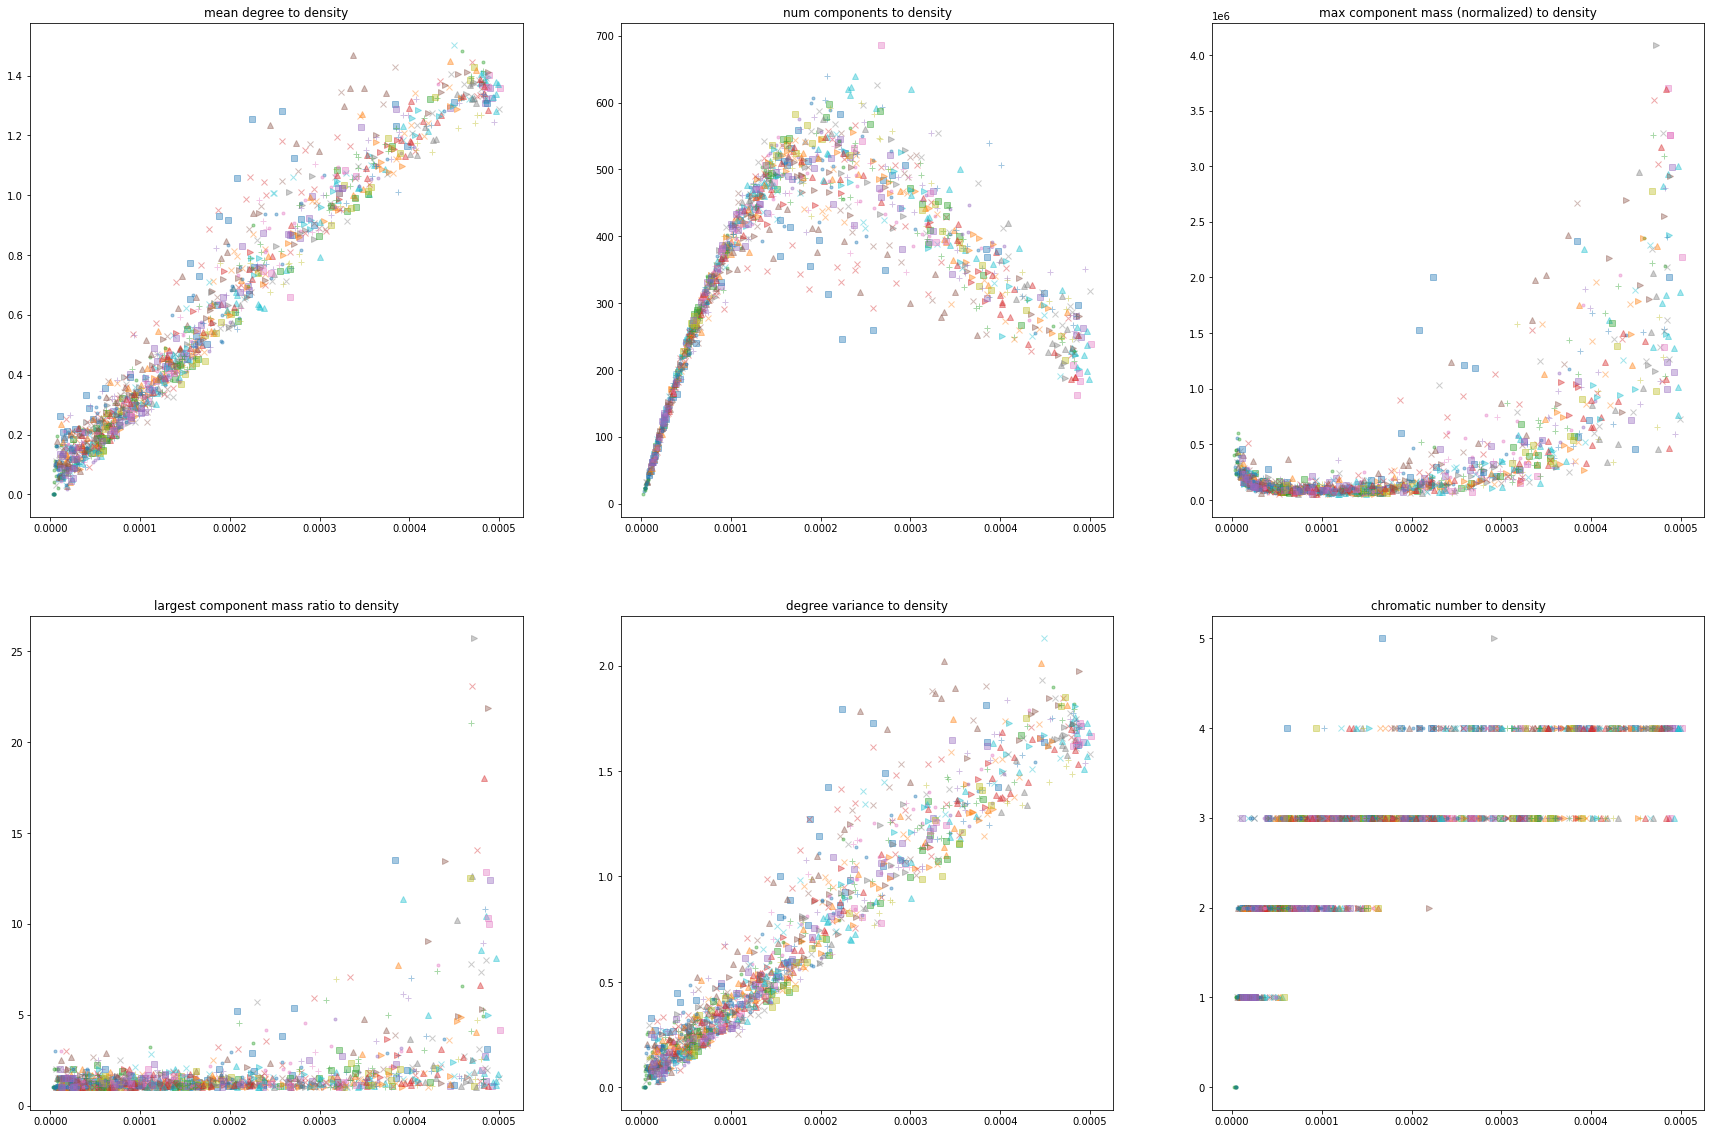

In [15]:
import itertools

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 20))

symbols = ['.','x','+','^','s','>']


def polyfit_rough(xdata,ydata,pdegree = 1, axes = None, color = None, label = "Fit function"):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    t = np.linspace(0, max(xdata), 1000)
    axes.plot(t, np.poly1d(popt)(t), label=label, color = color)

i = 0
ax1.set_title("mean degree to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree = [network.average_degree() for network in lineage.items]

    degree = [degree for _,degree in sorted(zip(density,degree))]
    density = sorted(density)
    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(density,degree, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    #polyfit_rough(density,degree,pdegree=1,axes = ax1, color = color, label = lineage.tag)
    i += 1
#ax1.legend()

i = 0
ax2.set_title("num components to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    num_components = [network.num_components for network in lineage.items]

    num_components = [num_components for _,num_components in sorted(zip(density,num_components))]
    density = sorted(density)
    color=next(ax2._get_lines.prop_cycler)['color']
    ax2.plot(density,num_components, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    #polyfit_rough(density,num_components,pdegree=2,axes = ax2, color = color, label = lineage.tag)
    i += 1
#ax2.legend()

i = 0
ax3.set_title("max component mass (normalized) to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    density = sorted(density)
    
    max_mass = np.divide(max_mass,density)
    color=next(ax3._get_lines.prop_cycler)['color']
    ax3.plot(density,max_mass, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    #polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color, label = lineage.tag)

    i += 1
#ax3.legend()
      
i = 0
ax4.set_title("largest component mass ratio to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    mass_ratio = [network.get_largest_comp_ratio() for network in lineage.items]

    mass_ratio = [mass_ratio for _,mass_ratio in sorted(zip(density,mass_ratio))]
    density = sorted(density)
    
    #mass_ratio = np.divide(mass_ratio,density)
    color=next(ax4._get_lines.prop_cycler)['color']
    ax4.plot(density,mass_ratio, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    #polyfit_rough(density,mass_ratio,pdegree=1,axes = ax4, color = color, label = lineage.tag)

    i += 1
#ax4.legend()

i = 0
ax5.set_title("degree variance to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree_var = [network.degree_variance() for network in lineage.items]

    degree_var = [degree_var for _,degree_var in sorted(zip(density,degree_var))]
    density = sorted(density)
    
    #degree_var = np.divide(degree_var,density)
    color=next(ax5._get_lines.prop_cycler)['color']
    ax5.plot(density,degree_var, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    #polyfit_rough(density,degree_var,pdegree=1,axes = ax5, color = color, label = lineage.tag)

    i += 1
#ax5.legend()

i = 0
ax6.set_title("chromatic number to density")
for lineage in tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    color=next(ax6._get_lines.prop_cycler)['color']
    ax6.plot(density,colornum, symbols[i%6], label = lineage.tag, color = color, alpha = 0.4)
    
    #polyfit_rough(density,colornum,pdegree=1,axes = ax6, color = color)
    i += 1
#ax6.legend()

#plt.savefig("densityPlots_9SCC.png", dpi = 75)

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


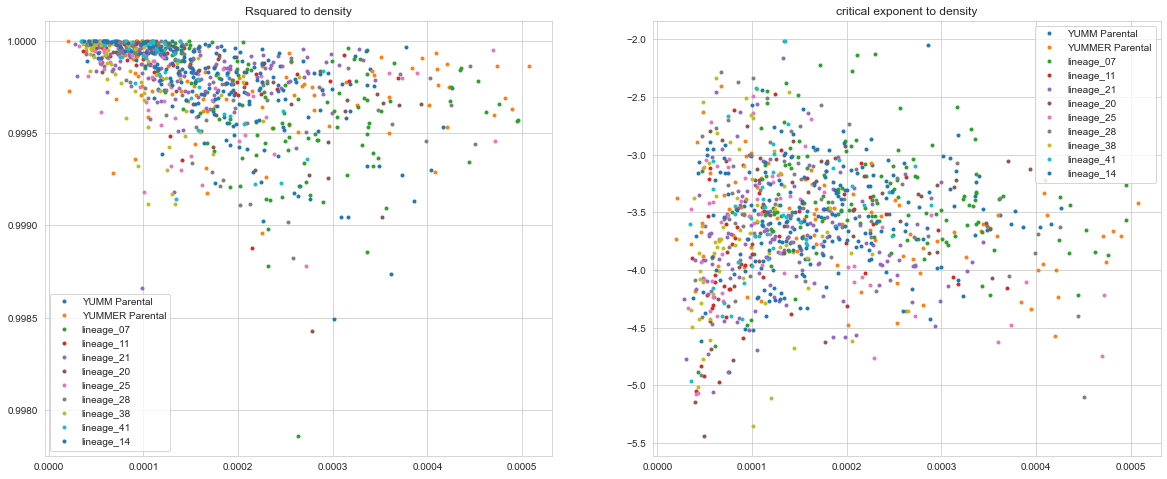

In [20]:
##TEMP, DELETE WHEN DONE



fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))

for lineage in lineage_list:
    lineage.plot_fit_params(ax1in=ax1,ax2in=ax2)

ax1.legend()
ax2.legend()

#plt.savefig("pwr_fitPlots_parental.png", dpi = 75)

In [21]:
def plot_to_density(lineage_list, method = None, title = 'property to density', symbols = ['.','x','+','^','s'], axes = None):
    
    if (ax is not None):
        ax = axes
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    i = 0
    ax.set_title(title)
    for lineage in lineage_list:
        density = [network.density for network in lineage.items]
        prop = [network.method.call() for network in lineage.items]

        prop = [prop for _,prop in sorted(zip(density,prop))]
        density = sorted(density)

        ax.plot(density,prop, symbols[i], label = lineage.tag)
        i += 1
    ax.legend()

In [22]:
#Curve Fitting And Comparison
#include power fitting as a method in networks: return fit function parameters and pererrs,
#plotting as a separate lineage method:
## Call to get fit parameters for each instance
def fit_power(network):
    from scipy.optimize import curve_fit
    components = network.get_component_masses()
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('cluster mass')
    ax1.set_ylabel('mass CDF')
    ax1.set_title('Cluster mass cumulative distribution function (log-log scale)')
    ax2.set_xlabel('cluster mass')
    ax2.set_ylabel('mass CDF')
    ax2.set_title('Cluster mass cumulative distribution function')
    
    #----------point plotting
    maxlen = max(components)
    data = np.zeros(maxlen+1)
    for pt in components:
        data[pt] += 1
    xdata = [index for index in range(len(data)) if data[index] != 0 ]
    ydata = [data[index] for index in range(len(data)) if data[index] != 0]
    ax1.plot(xdata, ydata, 'o', label='data')
    ax2.plot(xdata, ydata, 'o', label='data')
    
    
    def func(x, a, b):
        return a * np.power(x,b)
        #C not necessary if zero clusters = 0----------------------------------------------------------------
        
    def expfunc(x, a, b, c):
        try:
            np.exp(b*np.array(x))
        except FloatingPointError:
            m = []
            for i in x:
                try:
                    m.append(a*np.exp(b*i)+c)
                except FloatingPointError:
                    m.append(0)
            return m
        return a * np.exp(b*np.array(x)) + c
    
    #Logarithmic Binning - subject to tweaks
    #print(max(components))
    delimiters = np.logspace(0,np.log2(max(components)), int(np.log2(max(components)))+1, base = 2)
    bins = np.histogram(components, bins = delimiters)
    #print(delimiters)
    
    xdata = []
    ydata = []
    for i in range(len(bins[1])-1):
        xdata.append(bins[1][i+1]-bins[1][i])
    ydata = np.divide(bins[0],np.array(xdata))
    
    #plotting hist
    #ax1.plot(bins[1][0:len(bins[1])-1],ydata)
    #ax2.plot(bins[1][0:len(bins[1])-1],ydata)
    ax1.step(bins[1][1:len(bins[1])],ydata)
    ax2.step(bins[1][1:len(bins[1])],ydata)
    
    if len(ydata) < 2:
        return (float('nan'),float('nan'),float('nan')),float('nan'),float('nan')
    pwr_popt, pwr_pcov = curve_fit(func, xdata, ydata, p0=[500,-2], maxfev=5000)#---------------------------------
    exp_popt, exp_pcov = curve_fit(expfunc, xdata, ydata, p0=(180, -2, 0), maxfev=5000)#---------------------------------
    
    print(pwr_popt,exp_popt)
    
    pwr_perr = np.sqrt(np.diag(pwr_pcov))
    #modelPredictions = func(xdata, *popt)
    pwr_modelPredictions = func(xdata,*pwr_popt)
    pwr_absError = pwr_modelPredictions - ydata
    pwr_SE = np.square(pwr_absError) # squared errors
    pwr_MSE = np.mean(pwr_SE) # mean squared errors
    pwr_RMSE = np.sqrt(pwr_MSE) # Root Mean Squared Error, RMSE
    pwr_Rsquared = 1.0 - (np.var(pwr_absError) / np.var(ydata))
    
    exp_perr = np.sqrt(np.diag(exp_pcov))
    #modelPredictions = func(xdata, *popt)
    exp_modelPredictions = expfunc(xdata,*exp_popt)
    exp_absError = exp_modelPredictions - ydata
    exp_SE = np.square(exp_absError) # squared errors
    exp_MSE = np.mean(exp_SE) # mean squared errors
    exp_RMSE = np.sqrt(exp_MSE) # Root Mean Squared Error, RMSE
    exp_Rsquared = 1.0 - (np.var(exp_absError) / np.var(ydata))
    
    #plotting fit function
    t = np.linspace(1, max(components), 10000)
    ax1.plot(t, func(t, *pwr_popt), label="Fitted power function")
    ax2.plot(t, func(t, *pwr_popt), label="Fitted power function")
    
    ax1.plot(t, expfunc(t, *exp_popt), label="Fitted exponential function")
    ax2.plot(t, expfunc(t, *exp_popt), label="Fitted exponential function")
    
    ax1.legend()
    ax2.legend()
    
    return (pwr_popt, pwr_Rsquared, pwr_RMSE, pwr_pcov, pwr_perr,
            exp_popt, exp_Rsquared, exp_RMSE, exp_pcov, exp_perr, 
            xdata, ydata)
    
## to be called from lineage: plots instance power exp to density
def plot_fit_params(lineage, output = None, mindist = None):
    
    density = []
    popt = []
    Rsquared = []

    for network in lineage.items:
        #popt_temp, Rsquared_temp, RMSE, pcov, perr, xdata, ydata = network.fit_power()
        (pwr_popt_temp, pwr_Rsquared_temp, pwr_RMSE, pwr_pcov, pwr_perr,
         exp_popt_temp, exp_Rsquared_temp, exp_RMSE, exp_pcov, exp_perr,
         xdata, ydata) = network.fit_power()
        
        pwr_popt.append(pwr_popt_temp)
        pwr_Rsquared.append(pwr_Rsquared_temp)
        
        exp_popt.append(exp_popt_temp)
        exp_Rsquared.append(exp_Rsquared_temp)
        
        density.append(network.density)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    

    ax1.plot(density,Rsquared,'.',label = lineage.tag)
    
    ax2.plot(density,popt[1],'.',label = lineage.tag)
    
    
    #plt.suptitle(lineage.tag + '_' + mindist)
    #plt.savefig(output+'_'+mindist+'.png')
    #plt.show()


[172.30602877  -3.70256513] [ 1.92765934e+03 -2.48739714e+00  7.76745662e-01]
pwr Rsquared value = 0.9996002125856019
exp Rsquared value = 0.9995197697017699
1.000080481533503
8.044288383202147e-05


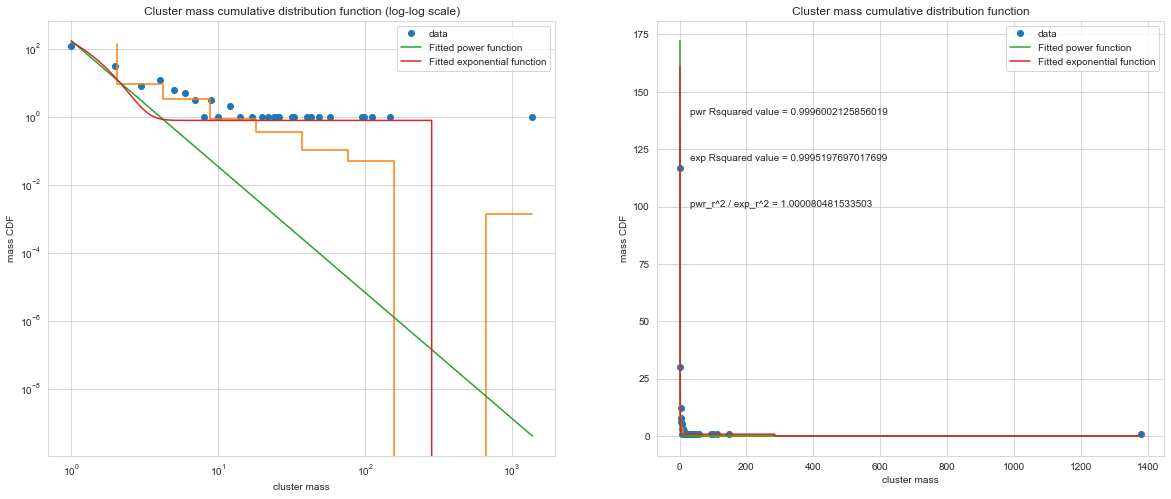

In [23]:
network = YMRP.items[126]
a = fit_power(network)
#print("critical exp = " + str(a[0][1]))
print("pwr Rsquared value = " + str(a[1]))
print("exp Rsquared value = " + str(a[6]))
print(a[1]/a[6])
print(a[1]-a[6])

plt.text(30, 140, "pwr Rsquared value = " + str(a[1]))
plt.text(30, 120, "exp Rsquared value = " + str(a[6]))
plt.text(30, 100, "pwr_r^2 / exp_r^2 = " + str(a[1]/a[6]))

#plt.savefig("Mass_CDF_fitting", dpi = 75)

fractal dimension:   0%|          | 0/128 [00:00<?, ?it/s]


KeyboardInterrupt: 

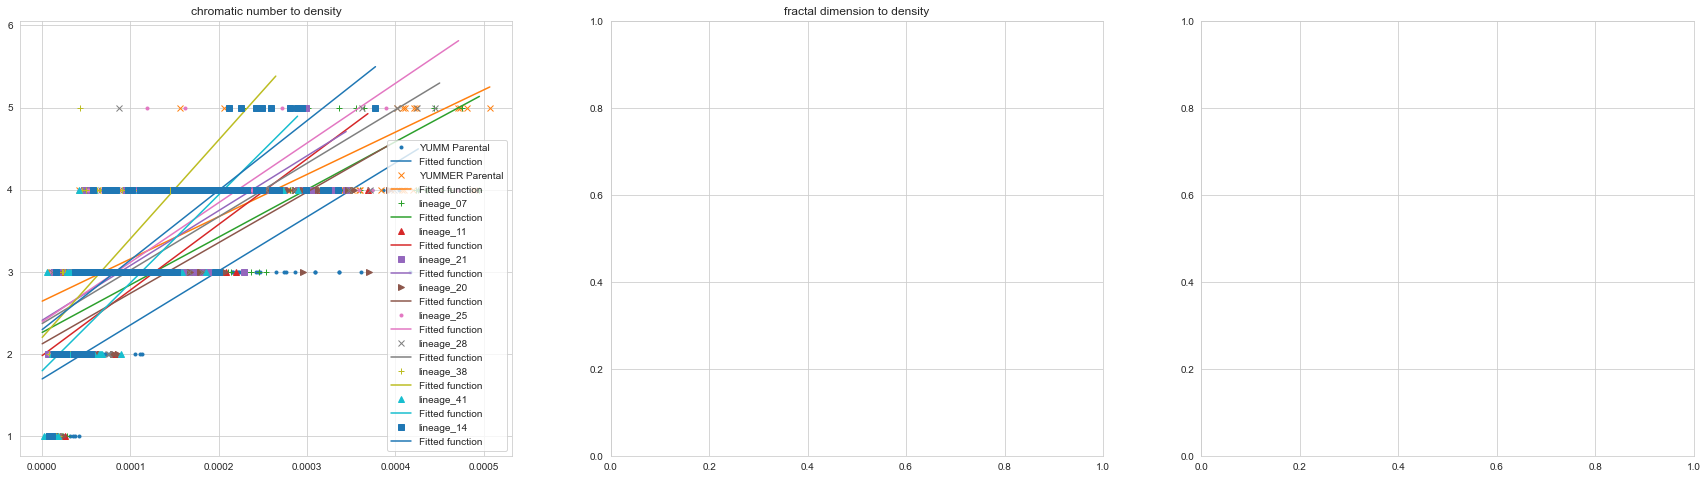

In [24]:
#Novel/Experimental Parameters


import itertools

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

symbols = ['.','x','+','^','s','>']


def polyfit_rough(xdata,ydata,pdegree = 1, axes = None, color = None):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    t = np.linspace(0, max(xdata), 1000)
    axes.plot(t, np.poly1d(popt)(t), label="Fitted function", color = color)

i = 0
ax1.set_title("chromatic number to density")
for lineage in tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(density,colornum, symbols[i%6], label = lineage.tag, color = color)
    
    polyfit_rough(density,colornum,pdegree=1,axes = ax1, color = color)
    i += 1
ax1.legend()

i = 0
ax2.set_title("fractal dimension to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    #fractaldim = [network.calc_fractal_dim() for network in lineage.items]
    fractaldim = []
    for network in tqdm(lineage.items, desc = "fractal dimension", position=0, leave=True):
        fractaldim.append(network.calc_fractal_dim()[1])
        

    fractaldim = [fractaldim for _,fractaldim in sorted(zip(density,fractaldim))]
    density = sorted(density)
    color=next(ax2._get_lines.prop_cycler)['color']
    ax2.plot(density,fractaldim, symbols[i%6], label = lineage.tag, color = color)
    
    polyfit_rough(density,fractaldim,pdegree=2,axes = ax2, color = color)
    i += 1
ax2.legend()

i = 0
ax3.set_title("max component mass (normalized) to density")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    density = sorted(density)
    
    max_mass = np.divide(max_mass,density)
    color=next(ax3._get_lines.prop_cycler)['color']
    ax3.plot(density,max_mass, symbols[i%6], label = lineage.tag, color = color)
    
    polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color)

    i += 1
ax3.legend()


In [16]:
#PCA
import pandas as pd
'''
each network has:

lineage
density
num components
mean degree (normalized)
max comp mass (normalized)
largest comp ratio
chromatic number
degree variance
power r^2
exp r^2
power exponent

'''


#Creating the dataframe

objs = []
for i,lineage in enumerate(tqdm(lineage_list, desc = "loading lineages", position=0, leave=True)):
    for network in lineage.items:
        density = network.density
        degree = network.average_degree()
        num_components = network.get_max_comp_mass()/density
        max_mass = network.get_max_comp_mass()/density
        mass_ratio = network.get_largest_comp_ratio()
        degree_variance = network.degree_variance()
        colornum = network.calc_chromatic()
        try:
            popt, Rsquared, RMSE, pcov, perr, xdata, ydata = network.fit_power()
        except RuntimeError:
            popt = (float('nan'),float('nan'),float('nan'))
            Rsquared = float('nan')

        critical_exp = popt[1]
        
        full = [i, density, degree, num_components, max_mass, mass_ratio, degree_variance, colornum, critical_exp, Rsquared]
        objs.append(full)

df = pd.DataFrame(objs, columns = ['lineage', 'density', 'degree', 'num_components', 'max_mass', 'mass_ratio', 
                                   'degree_variance', 'colornum', 'critical_exp', 'Rsquared']) 





loading lineages:   0%|          | 0/96 [00:00<?, ?it/s]/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


loading lineages:   1%|          | 1/96 [00:00<00:52,  1.81it/s]

loading lineages:   2%|▏         | 2/96 [00:00<00:47,  1.96it/s]

loading lineages:   3%|▎         | 3/96 [00:01<00:43,  2.13it/s]

loading lineages:   4%|▍         | 4/96 [00:01<00:38,  2.38it/s]

loading lineages:   5%|▌         | 5/96 [00:02<00:38,  2.36it/s]

loading lineages:   6%|▋         | 6/96 [00:02<00:35,  2.51it/s]

loading lineages:   7%|▋         | 7/96 [00:02<00:32,  2.76it/s]

loading lineages:   8%|▊         | 8/96 [00:02<00:28,  3.13it/s]

loading lineages:   9%|▉         | 9/96 [00:03<00:32,  2.66it/s]

loading lineages:  10%|█         | 10/96 [00:03<00:35,  2.42it/s]

loading lineages:  11%|█▏        | 11/96 [00:04<00:43,  1.95it/s]

loading 

In [93]:
#PCA
import pandas as pd
'''
each lineage has:

lineage
avg num components
avg mean degree (normalized)
avg max comp mass (normalized)
avg largest comp ratio
avg chromatic number
avg degree variance
avg power r^2
avg exp r^2
avg power exponent
'''


#Creating the dataframe

lowmid_cut = 0.00010
midhigh_cut = 0.00025

objs = []
for i,lineage in enumerate(tqdm(lineage_list, desc = "loading lineages", position=0, leave=True)):
    avg_degree = 0
    avg_numc = 0
    avg_maxmass = 0
    avg_degvar = 0
    avg_colornum = 0
    
    for network in lineage.items:
        density = network.density
        
        #For only taking midrange density 
        if density < lowmid_cut:
            continue
        if density >= midhigh_cut:
            continue
        avg_degree += network.average_degree()
        avg_numc += (network.get_max_comp_mass()/density)
        avg_maxmass += (network.get_max_comp_mass()/density)
        avg_degvar += network.degree_variance()
        avg_colornum += network.calc_chromatic()
        try:
            popt, Rsquared, RMSE, pcov, perr, xdata, ydata = network.fit_power()
        except RuntimeError:
            popt = (float('nan'),float('nan'),float('nan'))
            Rsquared = float('nan')

        critical_exp = popt[1]
        
    if len(lineage.items) == 0:
        continue
    avg_degree = avg_degree/len(lineage.items)
    avg_numc = avg_numc/len(lineage.items)
    avg_maxmass = avg_maxmass/len(lineage.items)
    avg_degvar = avg_degvar/len(lineage.items)
    avg_colornum = avg_colornum/len(lineage.items)
    
    full = [str(int(i/6)+1)+"."+str((i%6)+1), avg_degree, avg_numc, avg_maxmass, avg_degvar, avg_colornum]
    #print(str(int(i/6)+1)+"."+str((i%6)+1))
    objs.append(full)

df = pd.DataFrame(objs, columns = ['lineage', 'degree', 'num_components', 'max_mass',
                                   'degree_variance', 'colornum']) 





loading lineages:   9%|▉         | 9/96 [00:02<00:18,  4.65it/s]/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
loading lineages: 100%|██████████| 96/96 [00:11<00:00,  8.15it/s]


array([0.82635199, 0.15994818])

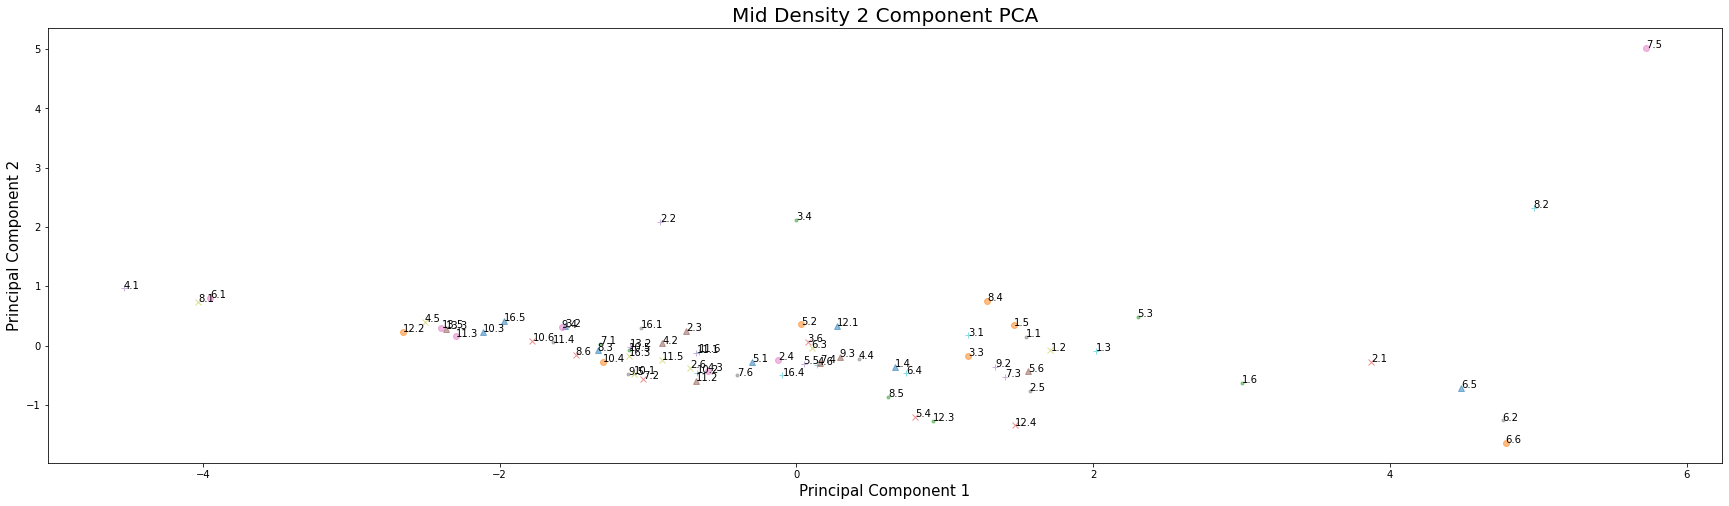

In [94]:
#Property Standardization

features = ['degree', 'num_components', 'max_mass', 'degree_variance', 'colornum']

x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
x = StandardScaler().fit_transform(x)

#PCA Projection

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

finalDf = pd.concat([principalDf, df[['lineage']]], axis = 1)



#Visualizer

fig, ax1 = plt.subplots(1, 1, figsize=(30, 8))

#ax = fig.add_subplot(1,1,1) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('Mid Density 2 Component PCA', fontsize = 20)

lineages = np.arange(0,95,1)

symbols = ['.','x','+','^','o',]

for i in range(len(finalDf)):
    indicesToKeep = finalDf['lineage'] == lineage
    color=next(ax6._get_lines.prop_cycler)['color']
    ax1.plot(finalDf.at[i, 'pc1']
          , finalDf.at[i, 'pc2']
          , symbols[i%5], color = color
          , alpha = 0.5)
    plt.annotate(finalDf.at[i,'lineage'],(finalDf.at[i, 'pc1'],finalDf.at[i, 'pc2']))
    
#ax.legend(lineages)

pca.explained_variance_ratio_

#plt.savefig("2 Component PCA.png", dpi = 75)



#import seaborn as sns

#ax2 = sns.jointplot(x=finalDf["pc1"], y=finalDf["pc2"], kind='kde', shade = False, color = 'gray')

#plt.savefig("lineage_"+str(i)+"_pc2.png", dpi = 50)

In [39]:
#generate different dataframes for low density, med density, high density:

lowmid_cut = 0.0001
midhigh_cut = 0.00025

df_l = df[df['density'] <= lowmid_cut]
df_m = df[df['density'] > lowmid_cut]
df_m = df_m[df_m['density'] <= midhigh_cut]
df_h = df[df['density'] > midhigh_cut]
print(len(df_l))
print(len(df_m))
print(len(df_h))


KeyError: 'density'

In [18]:
#Property Standardization

features = ['density', 'degree', 'num_components', 'max_mass', 'mass_ratio', 
            'degree_variance', 'colornum',]# 'critical_exp', 'Rsquared']
#features = ['num_components', 'max_mass', 'mass_ratio', 
#            'degree_variance', 'colornum',]# 'critical_exp', 'Rsquared']
x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
x = StandardScaler().fit_transform(x)

In [19]:
#PCA Projection

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

finalDf = pd.concat([principalDf, df[['lineage']], df[['density']]], axis = 1)

In [20]:
#generate different dataframes for low density, med density, high density:

lowmid_cut = 0.0001
midhigh_cut = 0.00025

df_l = finalDf[finalDf['density'] <= lowmid_cut]
df_m = finalDf[finalDf['density'] > lowmid_cut]
df_m = df_m[df_m['density'] <= midhigh_cut]
df_h = finalDf[finalDf['density'] > midhigh_cut]
print(len(df_l))
print(len(df_m))
print(len(df_h))


544
435
357


array([0.74161439, 0.18162861])

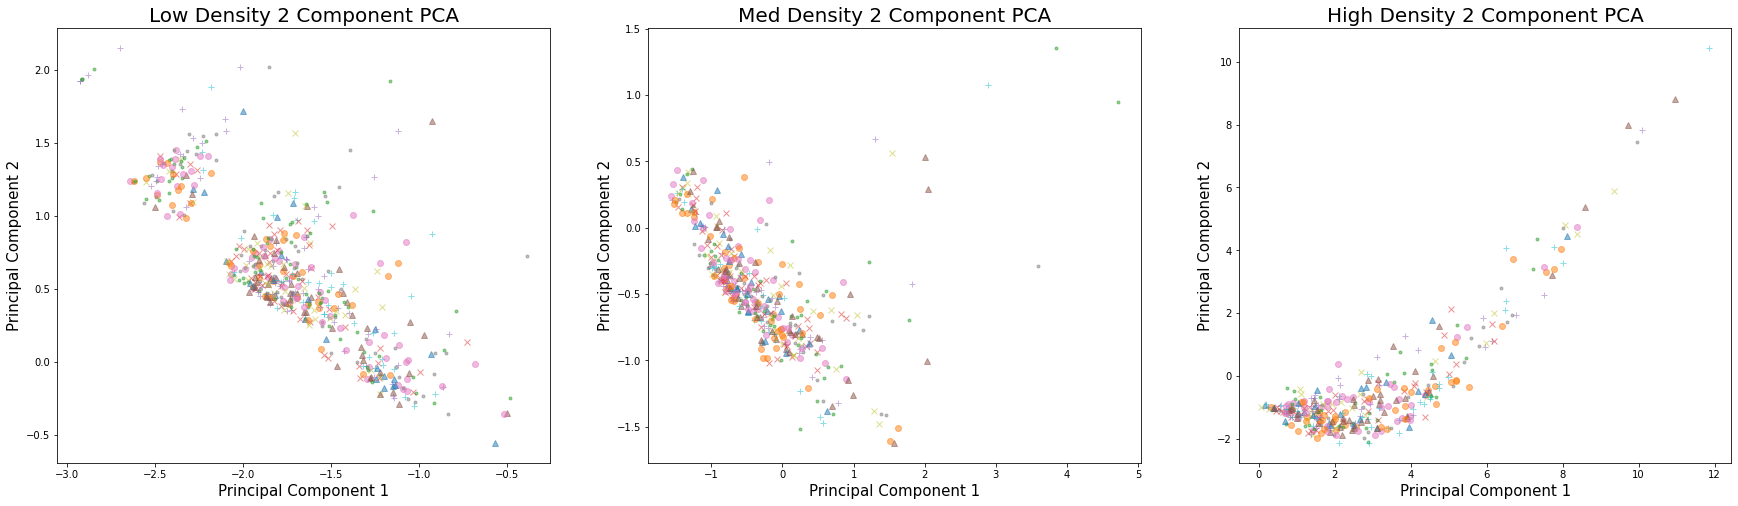

In [24]:
#fig = plt.figure(figsize = (14,14))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

#ax = fig.add_subplot(1,1,1) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('Low Density 2 Component PCA', fontsize = 20)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('Med Density 2 Component PCA', fontsize = 20)
ax3.set_xlabel('Principal Component 1', fontsize = 15)
ax3.set_ylabel('Principal Component 2', fontsize = 15)
ax3.set_title('High Density 2 Component PCA', fontsize = 20)

lineages = np.arange(0,95,1)

symbols = ['.','x','+','^','o',]

for i, lineage in enumerate(lineages):
    indicesToKeep = finalDf['lineage'] == lineage
    color=next(ax6._get_lines.prop_cycler)['color']
    ax1.plot(df_l.loc[indicesToKeep, 'pc1']
          , df_l.loc[indicesToKeep, 'pc2']
          , symbols[i%5], color = color
          , alpha = 0.5)
    ax2.plot(df_m.loc[indicesToKeep, 'pc1']
          , df_m.loc[indicesToKeep, 'pc2']
          , symbols[i%5], color = color
          , alpha = 0.5)
    ax3.plot(df_h.loc[indicesToKeep, 'pc1']
          , df_h.loc[indicesToKeep, 'pc2']
          , symbols[i%5], color = color
          , alpha = 0.5)

#ax1.legend(lineages)
#ax2.legend(lineages)
#ax3.legend(lineages)
pca.explained_variance_ratio_

#plt.text(-2, 16, "0:YMP, 1:YMRP, 2:lineage_07, 3:lineage_11, 4:lineage_21, 5:lineage_20, 6:lineage_25, 7:lineage_28, 8:lineage_38, 9:lineage_41, 10:lineage_14]")
#plt.text(-2, 15, "explained variance ratio = " + str(pca.explained_variance_ratio_))

#plt.savefig("2 Component PCA.png", dpi = 75)


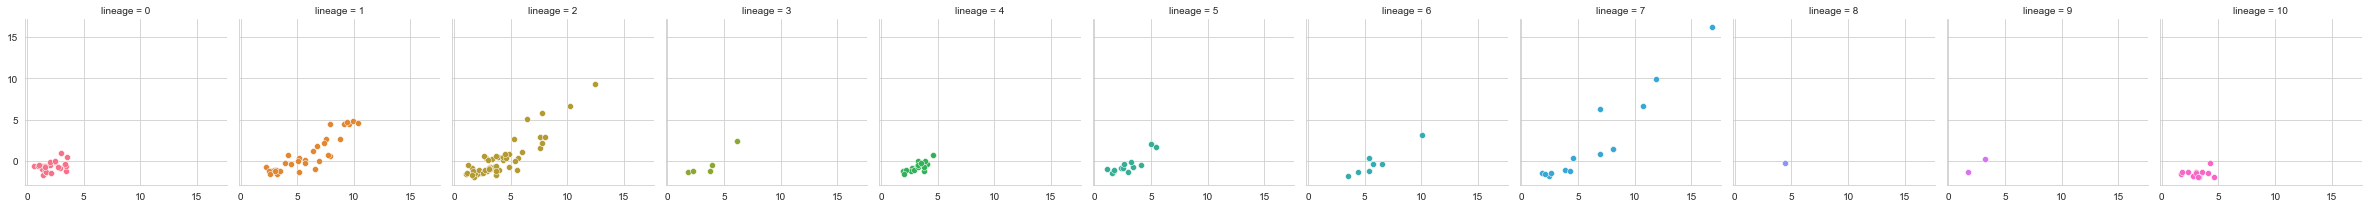

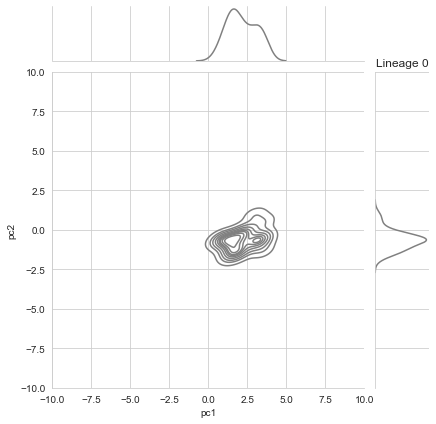

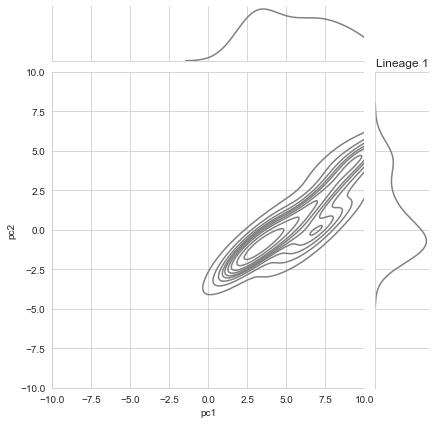

FloatingPointError: underflow encountered in exp

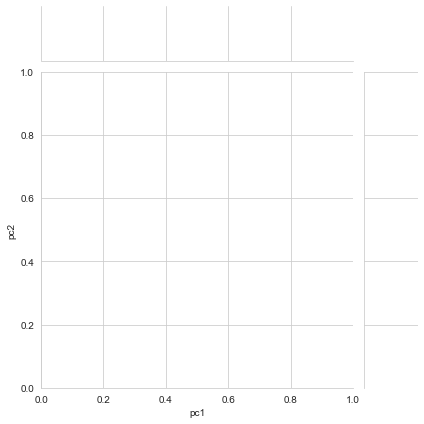

In [93]:
#Seaborn contour plotting

import seaborn as sns

plotdf = df_h

sns.set_style("whitegrid")
g = sns.FacetGrid(plotdf, col="lineage", hue="lineage")
g.map_dataframe(sns.scatterplot, x="pc1", y="pc2")

for i in range(len(lineages)):    
    lin = plotdf[plotdf["lineage"] == i]
    plot = sns.jointplot(x=lin["pc1"], y=lin["pc2"], kind='kde', shade = False, color = 'gray')
    plt.title('Lineage '+ str(i))
    plot.ax_marg_x.set_xlim(-10,10)
    plot.ax_marg_y.set_ylim(-10,10)
    #plt.savefig("lineage_"+str(i)+"_pc2.png", dpi = 50)
    plt.show()

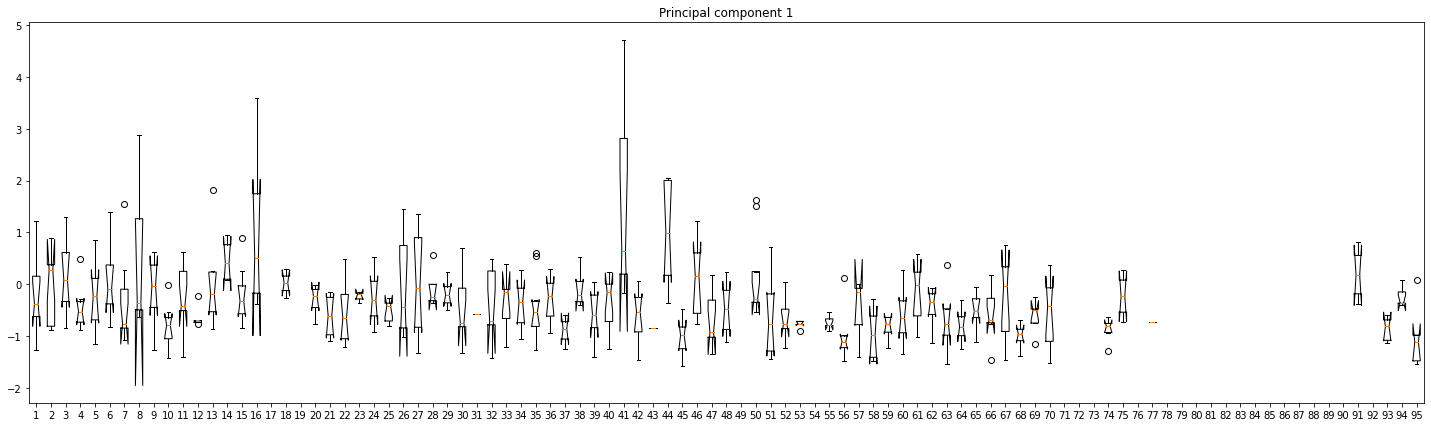

Text(0.5, 1.0, 'Principal component 2')

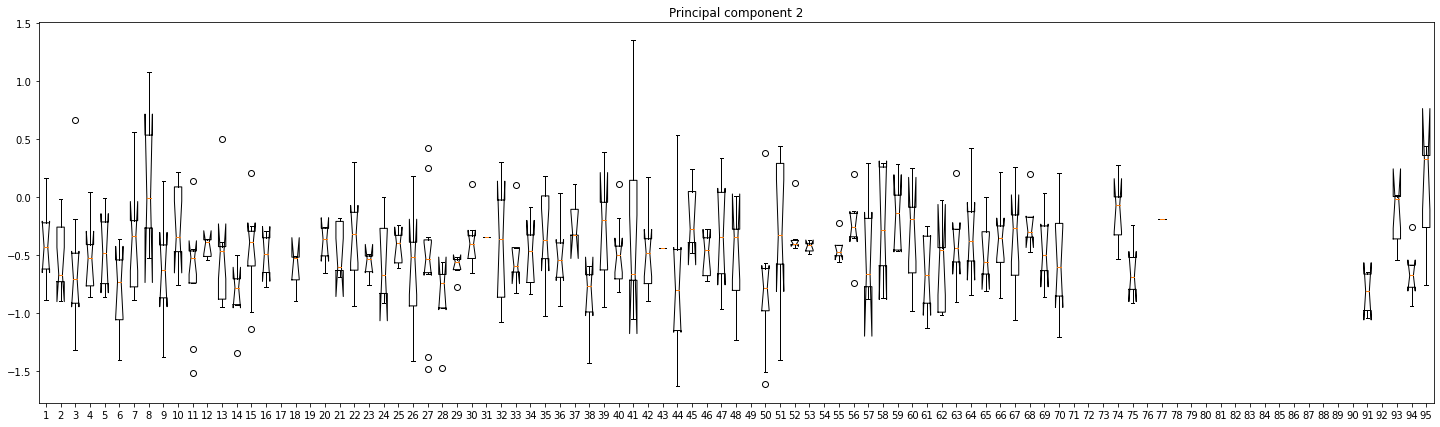

In [33]:
#boxplotting

#dataframe to plot
plotdf = df_m

#plotting script

plt.figure(figsize = (25,7))
boxes = []
for i, lineage in enumerate(lineages):
    indicesToKeep = plotdf['lineage'] == lineage
    color=next(ax6._get_lines.prop_cycler)['color']
    boxes.append(plotdf.loc[indicesToKeep, 'pc1'])
plt.boxplot(boxes, notch = True)
plt.title("Principal component 1")
#plt.savefig("PC1_11lineageComparison.png", dpi = 75)
plt.show()

boxes = []
plt.figure(figsize = (25,7))
for i, lineage in enumerate(lineages):
    indicesToKeep = plotdf['lineage'] == lineage
    color=next(ax6._get_lines.prop_cycler)['color']
    boxes.append(plotdf.loc[indicesToKeep, 'pc2'])
plt.boxplot(boxes, notch = True)
plt.title("Principal component 2")
#plt.savefig("PC2_11lineageComparison.png", dpi = 75)

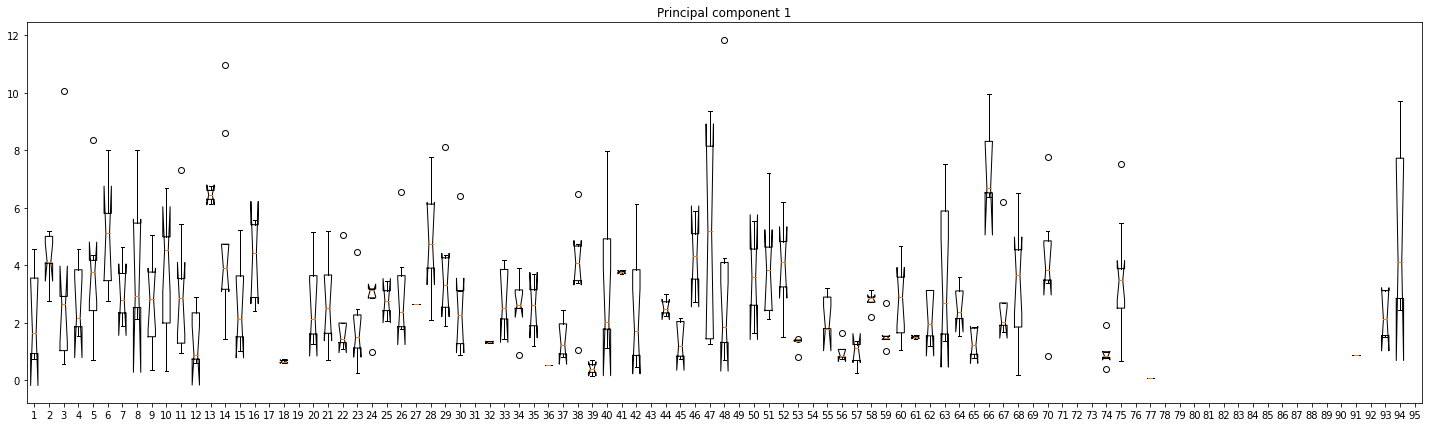

Text(0.5, 1.0, 'Principal component 2')

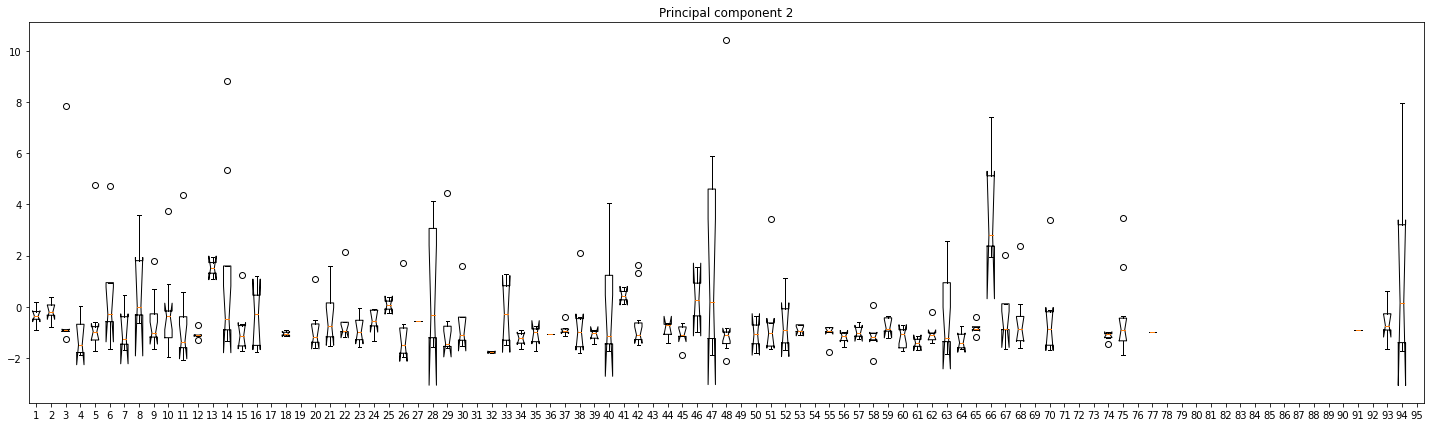

In [34]:
#boxplotting

#dataframe to plot
plotdf = df_h

#plotting script

plt.figure(figsize = (25,7))
boxes = []
for i, lineage in enumerate(lineages):
    indicesToKeep = plotdf['lineage'] == lineage
    color=next(ax6._get_lines.prop_cycler)['color']
    boxes.append(plotdf.loc[indicesToKeep, 'pc1'])
plt.boxplot(boxes, notch = True)
plt.title("Principal component 1")
#plt.savefig("PC1_11lineageComparison.png", dpi = 75)
plt.show()

boxes = []
plt.figure(figsize = (25,7))
for i, lineage in enumerate(lineages):
    indicesToKeep = plotdf['lineage'] == lineage
    color=next(ax6._get_lines.prop_cycler)['color']
    boxes.append(plotdf.loc[indicesToKeep, 'pc2'])
plt.boxplot(boxes, notch = True)
plt.title("Principal component 2")
#plt.savefig("PC2_11lineageComparison.png", dpi = 75)

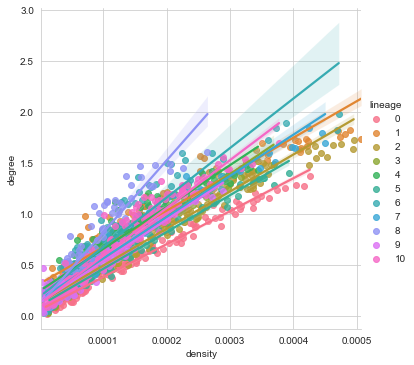

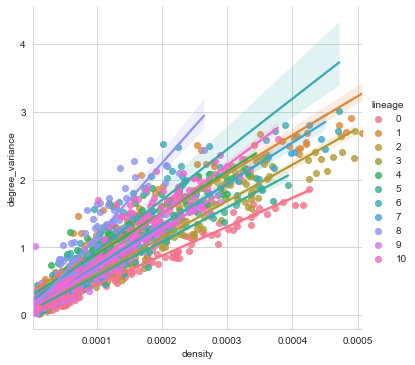

In [34]:
#Replotting some properties

'''
each network has:

['lineage', 'density', 'degree', 'num_components', 'max_mass', 'mass_ratio', 
                                   'degree_variance', 'colornum', 'critical_exp', 'Rsquared']

'''


sns.lmplot(data=df, x="density", y="degree", hue="lineage")
sns.lmplot(data=df, x="density", y="degree_variance", hue="lineage")

In [69]:
finalDf.loc[finalDf, 'pc1']

ValueError: Cannot index with multidimensional key

In [144]:
from sklearn.manifold import TSNE

#tsne_pre_df = pd.DataFrame()
features = ['density', 'degree', 'num_components', 'max_mass', 'mass_ratio', 
            'degree_variance', 'colornum',]

tsne_pre_df = pd.DataFrame()
tsne_pre_df = pd.concat([df[features]], axis = 1)

tsne_pre_df_l = tsne_pre_df[tsne_pre_df['density'] <= lowmid_cut]
tsne_pre_df_m = tsne_pre_df[tsne_pre_df['density'] > lowmid_cut]
tsne_pre_df_m = tsne_pre_df_m[tsne_pre_df_m['density'] <= midhigh_cut]
tsne_pre_df_h = tsne_pre_df[tsne_pre_df['density'] > midhigh_cut]

tsne_pre_df_m = tsne_pre_df_m.drop(['density'], axis = 1)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(tsne_pre_df_h)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 181 samples in 0.000s...
[t-SNE] Computed neighbors for 181 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 181 / 181
[t-SNE] Mean sigma: 1639.174945
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.008400
[t-SNE] KL divergence after 300 iterations: 0.189730


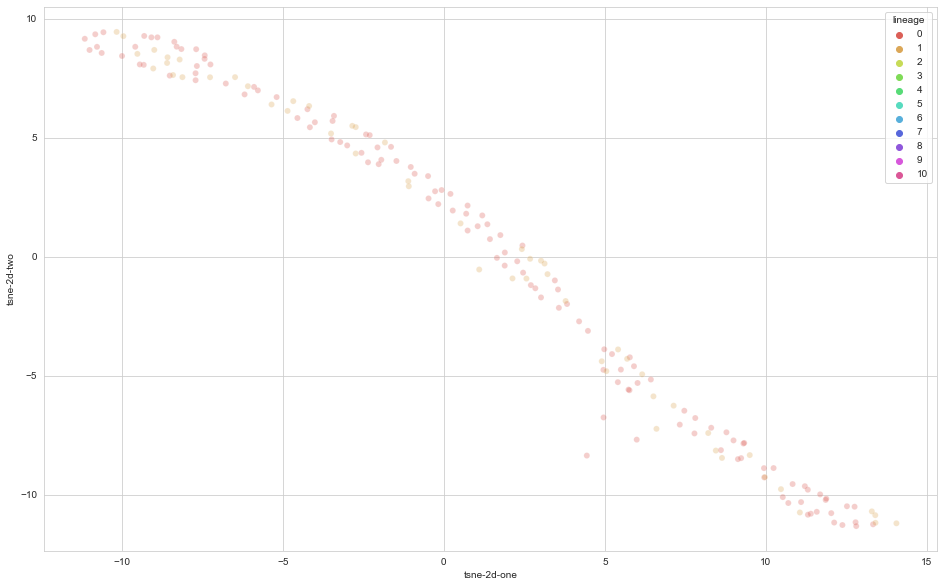

In [145]:
tsne_df = pd.DataFrame()
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df = pd.concat([tsne_df, df[['lineage']], df[['density']]], axis = 1)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="lineage",
    palette=sns.color_palette("hls", 11),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

In [146]:
tsne_pre_df_m

,degree,num_components,max_mass,mass_ratio,degree_variance,colornum
50,0.478955,129987.065312,129987.065312,1.142857,0.590036,3
51,0.441417,68635.029973,68635.029973,1.125000,0.476099,3
52,0.670352,185647.983920,185647.983920,1.064516,0.865066,4
54,0.409168,85531.599321,85531.599321,1.125000,0.483657,2
55,0.474797,109220.839024,109220.839024,1.200000,0.656937,3
...,...,...,...,...,...,...
1389,1.228571,701917.257143,701917.257143,1.373913,1.884171,4
1390,1.188418,570714.518760,570714.518760,1.785714,1.746511,4
1391,1.339785,505586.787097,505586.787097,1.105263,2.026501,5
1392,1.053862,204789.073171,204789.073171,1.028571,1.465051,4


KeyError: 'degree'